## analyze igabasnfr minis


In [2]:
import skimage, os
from skimage import io
'''
import image
'''

# file must be tif
fname = '/Users/zhengj10/Desktop/FOV_00006.tif'
save_dir = '/Users/zhengj10/Desktop/data/' # where to save processed movies

f_prefix, f_suffix = os.path.split(fname)

# filtering parameters
downsample_factor = 4 # downsample in time
acute_bleach_frames = 45 # remove acute bleaching component ~ 30 frames

# flood filling
tol_division_factor = 3 # higher number = lower threshold for flood filling
max_cloud_diameter = 40 # num pixels across largest cloud

# peak detection
percent_top = 40 # percent above which to consider peaks. Higher = more conservative (fewer peaks)

print('loading image...', end='')
im = io.imread(fname)
print('done')

loading image...done


In [3]:
'''
downsample image, save downsampled f(t)
'''
import numpy as np
from skimage.transform import downscale_local_mean
from skimage import exposure

print('downsampling...', end='')
im_ds = downscale_local_mean(im, (downsample_factor,1,1))
print('done')
im_ds = im_ds[acute_bleach_frames:,:,:]
im_ds = im_ds - np.min(im_ds)

# rescale to uint16 to save space
im_ds = exposure.rescale_intensity(im_ds, out_range='uint16')

print('saving downsampled image...', end='')
io.imsave(os.path.join(save_dir, f_suffix.replace('.tif', '_ds.tif')), im_ds)
print('done')

downsampling...done
saving downsampled image...done


In [4]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from skimage.filters.rank import median
from skimage import exposure

'''
filter image to get f0, subtract from image to get df(t)
'''

# smoothing in time to get f0
im_ds_filt = gaussian_filter1d(im_ds, sigma=20, axis=0)

# calculate df, restrict to positive going pixels
im_ds_filt[im_ds_filt >= im_ds] = im_ds[im_ds_filt >= im_ds]
df = im_ds - im_ds_filt

print('saving deltaF image...', end='')
io.imsave(os.path.join(save_dir, f_suffix.replace('.tif', '_df.tif')), df)
print('done')

saving deltaF image...done


/Users/zhengj10/opt/anaconda3/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


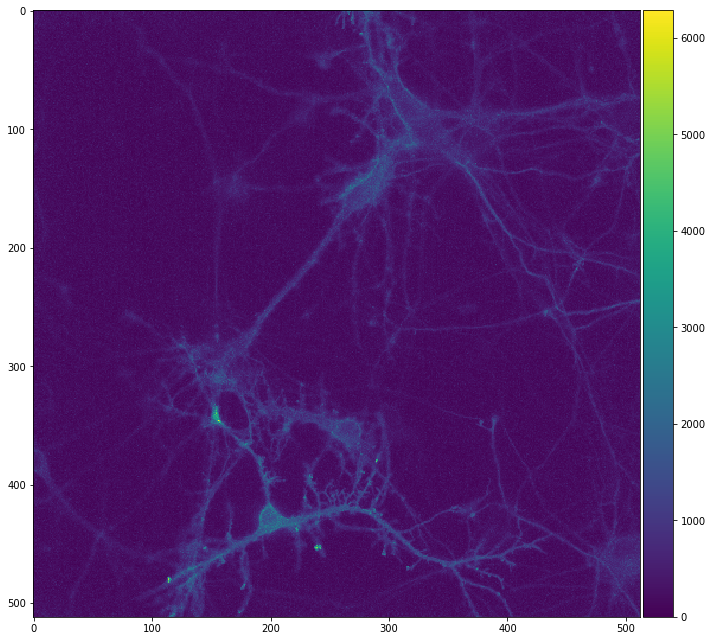

In [5]:
'''
calculate df_diff (max - median fluorescence to find hot spots)
'''
plt.figure(figsize=(10,10))
df_diff = np.max(df[20:,:,:],axis=0) - np.median(df[20:,:,:],axis=0)
df_diff = (df_diff-df_diff.min())
io.imshow(df_diff)

52428
47 blobs found


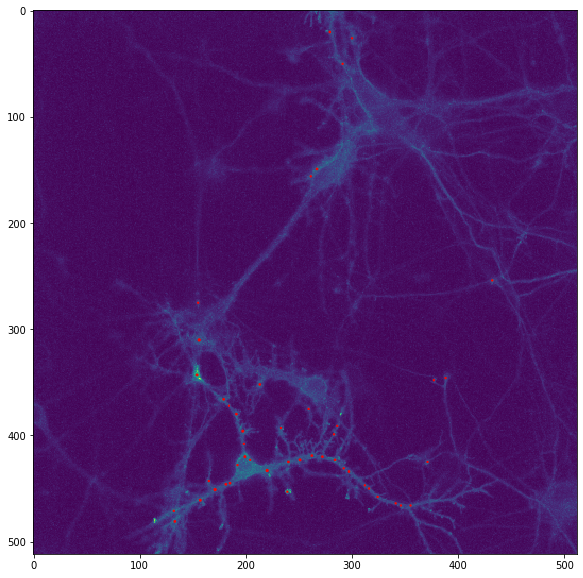

In [6]:
from skimage.feature import blob_log
from skimage.filters import gaussian
'''
do blob detection on df_dff to find hotspots, show image with blobs
'''
percent_top=20
def get_threshold_percent_top(arr, percent_top):
    '''
    arr: 1d or 2d np array
    percent_top: top percent of pixels
    return: pixel value above which percent_top pixels lie
    '''
    n_el_thresh = int(arr.size * percent_top / 100)
    print(n_el_thresh)
    return np.sort(arr.ravel())[::-1][n_el_thresh]

# mild gaussian filtering to smoothe out clouds
df_diff = gaussian(df_diff, sigma=0.4)

# returns [y,x,radius] array of found blobs
blobs = blob_log(df_diff, max_sigma=10, min_sigma=0.8, num_sigma=10, threshold=get_threshold_percent_top(df_diff,percent_top), exclude_border=20)

f,ax = plt.subplots(figsize=(10,10))
ax = plt.imshow(df_diff)
ax = plt.scatter(blobs[:,1], blobs[:,0], blobs[:,2] ,  color='red')
print('{} blobs found'.format(len(blobs)))

In [7]:
from skimage.morphology import flood_fill
from scipy.signal import find_peaks

max_cloud_radius = int(max_cloud_diameter/2)

def get_masked_trace(_b, _df, _radius):
    '''
    extract time trace corresponding to blob by flood filling pixels that are similar
    inputs:
        _b: blob coordinates (y,x)
        _df: [t x X x Y] movie
        _radius: max radius to fill
    
    returns:
        trace_out: df trace corresponding to found blob
        
    '''
    center_y = int(_b[0])
    center_x = int(_b[1])
    
    # df_cored: 'cored out' df with center on the blob [time x max blob W x max blob H]
    _df_cored = _df[:,slice(center_y-max_cloud_radius, center_y+max_cloud_radius), slice(center_x-max_cloud_radius, center_x+max_cloud_radius)]
    _df_cored_max = _df_cored.max(axis=0)
    
    # tolerance for flood filling (higher = more restrictive)
    tol=(_df_cored_max.max()-np.median(_df_cored_max))/tol_division_factor
    
    f = flood_fill(_df_cored_max, seed_point = (_radius,_radius),tolerance=tol, new_value=_df_cored_max.max())
    mask = (f == _df_cored_max.max())
    # print(mask.sum())
    
    # calculate trace from blob
    trace_out = _df_cored[:,mask].mean(axis=1)
    trace_out = (trace_out-trace_out.min()) / (trace_out.max() - trace_out.min())
    
    # return array of pixels that are in this blob to use as initialization for NMF
    dummy = np.zeros_like(_df[0], dtype='bool')

    df_dummy[slice(center_y-max_cloud_radius, center_y+max_cloud_radius), slice(center_x-max_cloud_radius, center_x+max_cloud_radius)] = mask
    return (trace_out, df_dummy.ravel())

blobs_yx = blobs[:,[0,1]] # only y and x coords of blobs

n_blobs = blobs_yx.shape[0]
n_px = df_diff.size
n_bg = round(n_blobs/2)
n_frames = df.shape[0]
print('# blobs: {}'.format(n_blobs))
masked_img = np.zeros_like(df_diff)
dfs = []
peak_arr = []
blob_yx_filtered = []

# initialize NMF guess for W0
W0_init = np.zeros((n_px, n_blobs+n_bg))
H0_init = np.zeros((n_blobs + n_bg, n_frames)) # initial H0 guess: [n components x time]
i=0
for b in blobs_yx:

    (masked_trace, pixels_in_blob) = get_masked_trace(b, df, max_cloud_radius)
    peaks, _ = find_peaks(masked_trace, distance=10, prominence=0.5)
    W0_init[:,i] = pixels_in_blob
    H0_init[i,:] = masked_trace
    i+=1
    if peaks.size > 0: # and peaks.size<20:
        dfs.append(masked_trace)
        peak_arr.append(peaks)
        blob_yx_filtered.append(b)

blob_yx_filtered = np.array(blob_yx_filtered)
print('# traces: {}'.format(len(peak_arr)))
# dfs_sorted = sorted(dfs, key=lambda x: x.max()-x.min())
f, ax = plt.subplots(figsize=(10,10))

delta=0
i=0
for x in dfs:
    ax.plot(x + delta)
    ax.plot(peak_arr[i], x[peak_arr[i]]+delta, 'rx')
    delta+=1
    i+=1


_,ax = plt.subplots(figsize=(10,10))
ax = plt.imshow(df_diff)
ax = plt.plot(blob_yx_filtered[:,1], blob_yx_filtered[:,0],'r.', markersize=5 ) 

# blobs: 47


NameError: name 'df_dummy' is not defined

In [ ]:
n_blobs

In [ ]:
from sklearn.decomposition import NMF
from skimage.filters.rank import median
from skimage.morphology import disk
df_2d = df.reshape([df.shape[0], df.shape[1]*df.shape[2]]).T

sparse_fraction = 0.01
n_iters = 1
min_num_els_in_comp = 5 # minimum number of elements in component

# initialize bg components to noise
W0_init[:,n_blobs:] = np.random.rand(n_px, n_bg)/n_bg
H0_init[n_blobs:,:] = np.random.rand(n_bg, n_frames)/n_frames

W0 = W0_init
H0 = H0_init
for i in range(n_iters):
    model = NMF(n_components=n_blobs+n_bg, 
                init='custom', 
                l1_ratio=0.8, 
                verbose=1, 
                max_iter=1,
               #regularization='transformation',
               alpha=0.01)
    W0 = model.fit_transform(df_2d, W=W0, H=H0)
    H0 = model.components_
    
    # sparsify W0
    eligible_nonsparse_cols = np.tile((np.count_nonzero(W0,axis=0) > min_num_els_in_comp), (n_px,1)) # columns eligible for sparsification if they have >min_num_els_in_comp nonzero elements
    W0[np.logical_and(eligible_nonsparse_cols, W0 < sparse_fraction * W0.max())] = 0
    
    W0 = W0/np.max(W0,axis=0) # regularize W0
    
    # median filter to remove single pixels
    
    
    for c in range(W0.shape[1]):
        w = W0[:,c].reshape(512,512,-1).squeeze() # reshape back to image
        W0[:,c] = median(w, disk(2)).reshape(n_px,-1).squeeze()
    
    print(np.count_nonzero(W0,axis=0))

In [ ]:
def show_components(w, imgsize):
    '''
    visualize components on image
    w: [# pixels x n components] weight matrix
    imgsize: [w x h] of image
    
    return (r,g,b) corresponding to colors on the visualization plot
    '''
    _n_px = w.shape[0]
    _n_comps = w.shape[1]
    _r,_g,_b = (np.random.rand(_n_comps), 
                np.random.rand(_n_comps), 
                np.random.rand(_n_comps))
    
    _r_tiled,_g_tiled,_b_tiled = (np.tile(_r,(_n_px,1)), 
                np.tile(_g,(_n_px,1)), 
                np.tile(_b,(_n_px,1)))
    w_r, w_g,w_b = w * (_r_tiled,_g_tiled,_b_tiled)

    w_combo = np.array([w_r.reshape(imgsize[0],imgsize[1],-1)/w_r.max(), 
                        w_g.reshape(imgsize[0],imgsize[1],-1)/w_r.max(),
                        w_b.reshape(imgsize[0],imgsize[1],-1)/w_r.max()]).sum(-1)
    w_combo = np.swapaxes(np.swapaxes(w_combo, 0,2), 0,1)

    plt.subplots(figsize=(10,10))
    plt.imshow(w_combo)
    
    return(_r,_g,_b)
r,g,b = show_components(W0, df_diff.shape)

f, ax = plt.subplots(figsize=(10,10))
delta=0
for i in range(n_blobs+n_bg):
    trace = H0[i,:]
    w = W0[:,i]
    if any(trace>0) and sum(w)>2:
        delta+=10
        ax.plot(trace+delta, color=[r[i],g[i],b[i]])

In [ ]:
w.shape

In [ ]:
xx = W0.reshape([512,512,-1])

for i in range(10):
    plt.figure(figsize=[5,5])
    plt.imshow(xx[:,:,20+i])

In [ ]:
xx.shape